In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

import matplotlib.pyplot as plt
import sys
import os
# import warnings
# warnings.filterwarnings('ignore')

#user = 'madams01'
#sys.path.append(f'/home/{user}/git_clones/copymltox/ml-tox/src')
sys.path.append("/home/ishah/ipynb/ml-tox/src")
from mltox.db.mongo import *
from mltox.db.bc import *
from mltox.db.bio import *
#from mltox.db.graph_utils import *

import functools
import seaborn as sns

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [19]:
# os.environ['CUDA_VISIBLE_DEVICES']=''
!CUDA_VISIBLE_DEVICES='0'
!export CUDA_VISIBLE_DEVICES
os.getenv('CUDA_VISIBLE_DEVICES')


# Data

In [5]:
GNR = openMongo(db='genra_dev_v5',auth=False,host='localhost')

## ATG

In [2]:
DAT='/home/ishah/ipynb/ml-tox/data/bio/'
CH_ATG = pd.read_csv(DAT+'chm-atg.csv')
CH_ATG

,dsstox_sid,smiles,ATG_AP_1_CIS,ATG_AP_2_CIS,ATG_AR_TRANS,ATG_Ahr_CIS,ATG_BRE_CIS,ATG_CAR_TRANS,ATG_CMV_CIS,ATG_CRE_CIS,...,ATG_Sp1_CIS,ATG_TAL_CIS,ATG_TA_CIS,ATG_TCF_b_cat_CIS,ATG_TGFb_CIS,ATG_THRa1_TRANS,ATG_VDRE_CIS,ATG_VDR_TRANS,ATG_Xbp1_CIS,ATG_p53_CIS
0,DTXSID0020232,CN1C=NC2=C1C(=O)N(C)C(=O)N2C,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,DTXSID0020236,[Ca++].CC(O)C([O-])=O.CC(O)C([O-])=O,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,DTXSID0020280,[O-][N+](=O)C1=C(Cl)C=CC=C1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,DTXSID0020282,NC1=CC(N)=C(Cl)C=C1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,DTXSID0020284,OS(O)(=O)=O.NC1=CC=C(N)C(Cl)=C1,1,0,1,1,0,0,1,1,...,1,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,DTXSID9051907,COC1=NC=CN=C1CC(C)C,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3475,DTXSID9052505,CCCCC(C)=C,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3476,DTXSID9052509,OC1=CC=C(C=C1)C#N,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3477,DTXSID9052846,COCC(C)N(C(=O)CS(O)(=O)=O)C1=CSC=C1C,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
CHM = pd.DataFrame(GNR.compounds.find(dict(dsstox_sid={'$in':CH_ATG.dsstox_sid.tolist()}),
                                     dict(_id=0,dsstox_sid=1,name=1))).set_index('dsstox_sid')
CHM.head()

,name
dsstox_sid,
DTXSID0020232,Caffeine
DTXSID0020236,Calcium lactate
DTXSID0020280,1-Chloro-2-nitrobenzene
DTXSID0020282,"4-Chloro-1,3-diaminobenzene"
DTXSID0020284,"2-Chloro-1,4-diaminobenzene sulfate (1:1)"


In [4]:
'DTXSID9047203' in CH_ATG.dsstox_sid.tolist(),\
'DTXSID9022445' in CH_ATG.dsstox_sid.tolist(),\
'DTXSID0020232' in CH_ATG.dsstox_sid.tolist()

(True, True, True)

## ER


In [37]:
ER1 = pd.read_csv('/home/ishah/ipynb/ml-tox/data/bio/ER-pmi.csv')

In [38]:
ER1_pos = ER1[(ER1.er_class.isin([1])) & (ER1.ESR1_coc>=40) & (ER1.er_class==1)]
X=ER1_pos.sort_values('ESR1_pmi',ascending=False).head(20)
SID_pos = X.dtxsid.tolist()
ER1_neg = ER1[(ER1.er_class.isin([0])) & (ER1.n_chem>=1e3) & (ER1.ESR1_pmi<=0) & (ER1.er_class==0)]
X = ER1_neg.sort_values('ESR1_pmi',ascending=False).head(20)
SID_neg = X.dtxsid.tolist()


In [34]:
len(SID_pos),len(SID_neg)
SID_pos,SID_neg

(['DTXSID8022377',
  'DTXSID3022320',
  'DTXSID3020465',
  'DTXSID5022308',
  'DTXSID7020182',
  'DTXSID5020576',
  'DTXSID9022310',
  'DTXSID4022367',
  'DTXSID9022360',
  'DTXSID9020827',
  'DTXSID9022364',
  'DTXSID6022345',
  'DTXSID3022409',
  'DTXSID9022366',
  'DTXSID1022394',
  'DTXSID8024523',
  'DTXSID4020379',
  'DTXSID9023380',
  'DTXSID7020768',
  'DTXSID6022391'],
 ['DTXSID0025816',
  'DTXSID0021206',
  'DTXSID6021666',
  'DTXSID0020232',
  'DTXSID5021251',
  'DTXSID1020855',
  'DTXSID9021392',
  'DTXSID8025595',
  'DTXSID9020249',
  'DTXSID4042416',
  'DTXSID6026080',
  'DTXSID0020652',
  'DTXSID4021426',
  'DTXSID2027200',
  'DTXSID3021518',
  'DTXSID0034300',
  'DTXSID0021834',
  'DTXSID5026918',
  'DTXSID0027195',
  'DTXSID5020730'])

,dtxsid,refchem_agonist,refchem_antagonist,auc_agonist,er_class,chemical,ESR1_pmi,ESR2_pmi,ESRRA_pmi,ESRRB_pmi,ESRRG_pmi,ESR1_coc,ESR2_coc,ESRRA_coc,ESRRB_coc,ESRRG_coc,n_chem
0,DTXSID8022377,moderate,NaN,1.060,1.0,Alfatradiol,0.426793,0.377710,0.000000,0.000000,0.0,157,16,0,0,0,485
1,DTXSID5020576,strong,inactive,1.000,1.0,Ethinyl estradiol,0.324533,0.000000,0.150614,0.052318,0.0,363,0,1,1,0,4914
2,DTXSID2022381,strong,NaN,0.993,1.0,meso-Hexestrol,0.356232,0.000000,0.000000,0.000000,0.0,2,0,0,0,0,3
3,DTXSID3020465,strong,inactive,0.943,1.0,Diethylstilbestrol,0.375444,0.296599,0.351990,0.213453,0.0,313,22,7,5,0,2295
4,DTXSID0020573,NaN,NaN,0.935,1.0,Estradiol,0.000000,0.000000,0.231188,0.000000,0.0,0,0,20,0,0,50558


In [39]:
ER1.insert(1,'Positive',ER1.dtxsid.apply(lambda i: 1 if i in SID_pos else 0))
ER1.insert(1,'Negative',ER1.dtxsid.apply(lambda i: 1 if i in SID_neg else 0))

In [40]:
SI3 = ER1[['dtxsid','chemical','ESR1_pmi','er_class','ESR1_pmi','ESR1_coc','n_chem','Positive','Negative']]

In [43]:
SI3.to_csv('/home/ishah/ipynb/ml-tox/data/bio/SI3-ER-validation-pmi.csv',index=None)

In [10]:
def keepChem(DSa):
    Keep=[]
    for i,v in enumerate(DSa.X):
        #print(i.num_nodes)
        try:
            n = v.num_nodes
        except:
            print(i)
        else:
            Keep.append(i)
    
    return DSa.select(Keep),Keep
    

In [25]:
import deepchem as dc
DAT='/home/ishah/ipynb/ml-tox/data/bio/'
CH_ATG = pd.read_csv(DAT+'chm-atg.csv')
Y_names = CH_ATG.columns[2:]
CH_ATG_train = CH_ATG[~CH_ATG.dsstox_sid.isin(SID_neg+SID_pos)]

DS_train = dc.data.NumpyDataset(CH_ATG_train.smiles,CH_ATG_train.iloc[:,2:])
FT = dc.trans.FeaturizationTransformer(DS_train, dc.feat.MolGraphConvFeaturizer(use_edges=True))
DS_train = FT.transform(DS_train)
DS_train,x = keepChem(DS_train)

CH_ATG_test = CH_ATG[CH_ATG.dsstox_sid.isin(SID_neg+SID_pos)]

DS_test = dc.data.NumpyDataset(CH_ATG_test.smiles,CH_ATG_test.iloc[:,2:])
FT = dc.trans.FeaturizationTransformer(DS_test, dc.feat.MolGraphConvFeaturizer(use_edges=True))
DS_test = FT.transform(DS_test)
DS_test,x = keepChem(DS_test)



Failed to featurize datapoint 237, [Br-].[Br-].[Ca+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 265, [Cl-].[Cl-].[Cl-].[Yb+3]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 903, [Cl-].[Cl-].[Zn+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 922, [I-].[Na+]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 1488, [Cl-].[Cl-].[Pd+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 1749, [Cl-].[Cl-].[Hg+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 1956, [Cu+].[I-]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 2640, [Cl-].[Cl-].[Ni+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3008, [C

237
265
903
922
1488
1749
1956
2640
3008
3301


In [122]:
DS_train.X.shape, DS_test.X.shape

((3429,), (40,))

In [26]:
import deepchem as dc
DAT='/home/ishah/ipynb/ml-tox/data/bio/'
CH_ATG = pd.read_csv(DAT+'chm-atg.csv')
Y_names = CH_ATG.columns[2:]

DS_full = dc.data.NumpyDataset(CH_ATG.smiles)
FT = dc.trans.FeaturizationTransformer(DS_full, dc.feat.MolGraphConvFeaturizer(use_edges=True))
DS_full = FT.transform(DS_full)
DS_full,SID_keep = keepChem(DS_full)



Failed to featurize datapoint 244, [Br-].[Br-].[Ca+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 272, [Cl-].[Cl-].[Cl-].[Yb+3]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 913, [Cl-].[Cl-].[Zn+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 932, [I-].[Na+]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 1505, [Cl-].[Cl-].[Pd+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 1769, [Cl-].[Cl-].[Hg+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 1979, [Cu+].[I-]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 2669, [Cl-].[Cl-].[Ni+2]. Appending empty array
Exception message: tuple index out of range
Failed to featurize datapoint 3040, [C

244
272
913
932
1505
1769
1979
2669
3040
3341


# AFP

In [12]:
# CH1 = pd.read_csv('/home/ishah/ipynb/ml-tox/data/chm/CCD-Batch-Search_2024-01-05_10_40_53.csv')
# CH1.columns=CH1.columns.str.lower()
# CH1 = CH1[['dtxsid','smiles']].dropna()
# ER2 = ER0.merge(CH1,on='dtxsid')
# CH1.shape,ER0.shape,ER2.shape

In [28]:
import deepchem as dc
from deepchem.models.torch_models import AttentiveFPModel
#import scipy


In [30]:
# AFP1 = AttentiveFPModel(mode='classification',                             
#                             n_tasks=DS_train.y.shape[1],
#                             num_layers=2,
#                             graph_feat_size=100,
#                             batch_size=16, 
#                             verbose=True,                            
#                             learning_rate=0.001)
from mltox.ml.attentive_fp_weights import *
MODEL='/home/ishah/ipynb/ml-tox/models/'
AFP1 = AttentiveFPModelWeights(mode='classification', 
                                n_tasks=DS_train.y.shape[1],
                                graph_feat_size=200,
                                batch_size=16, 
                                num_layers = 2,
                                num_timesteps = 2,
                                learning_rate=0.001,
                                model_dir=MODEL+'afp2/'                                
                                )

#AFP1.fit(DS_train,nb_epoch=40)
AFP1.restore(model_dir=MODEL+'afp2/')

In [31]:
{i:Y_names.get_loc(i) for i in Y_names[Y_names.str.contains('ER')]}

{'ATG_ERE_CIS': 13,
 'ATG_ERRa_TRANS': 14,
 'ATG_ERRg_TRANS': 15,
 'ATG_ERa_TRANS': 16}

In [32]:
AFP1_pred = AFP1.predict(DS_full)

In [33]:
ER_pred0 = pd.DataFrame(dict(dtxsid=CH_ATG.dsstox_sid.iloc[SID_keep],ERa_TRANS_pred=AFP1_pred[:,16,1],
                           ERE_CIS_pred=AFP1_pred[:,13,1]))
ER_pred = ER1.merge(ER_pred0,on='dtxsid').drop_duplicates()

ER_pred.insert(ER_pred.shape[1],'ERa_TRANS_pred_bin', ER_pred.ERa_TRANS_pred.apply(lambda i: 0 if i<0.5 else 1))
ER_pred.insert(ER_pred.shape[1],'ERE_CIS_pred_bin', ER_pred.ERE_CIS_pred.apply(lambda i: 0 if i<0.5 else 1))
ER_pred.head()

,dtxsid,refchem_agonist,refchem_antagonist,auc_agonist,er_class,chemical,ESR1_pmi,ESR2_pmi,ESRRA_pmi,ESRRB_pmi,...,ESR1_coc,ESR2_coc,ESRRA_coc,ESRRB_coc,ESRRG_coc,n_chem,ERa_TRANS_pred,ERE_CIS_pred,ERa_TRANS_pred_bin,ERE_CIS_pred_bin
0,DTXSID8022377,moderate,NaN,1.060,1.0,Alfatradiol,0.426793,0.377710,0.000000,0.000000,...,157,16,0,0,0,485,0.884233,0.860397,1,1
1,DTXSID5020576,strong,inactive,1.000,1.0,Ethinyl estradiol,0.324533,0.000000,0.150614,0.052318,...,363,0,1,1,0,4914,0.828903,0.835434,1,1
2,DTXSID2022381,strong,NaN,0.993,1.0,meso-Hexestrol,0.356232,0.000000,0.000000,0.000000,...,2,0,0,0,0,3,0.955037,0.941349,1,1
3,DTXSID3020465,strong,inactive,0.943,1.0,Diethylstilbestrol,0.375444,0.296599,0.351990,0.213453,...,313,22,7,5,0,2295,0.989776,0.986249,1,1
4,DTXSID0020573,NaN,NaN,0.935,1.0,Estradiol,0.000000,0.000000,0.231188,0.000000,...,0,0,20,0,0,50558,0.884233,0.860397,1,1


In [34]:
ER_pred0.head()

,dtxsid,ERa_TRANS_pred,ERE_CIS_pred
0,DTXSID0020232,0.246407,0.265012
1,DTXSID0020236,0.146052,0.334513
2,DTXSID0020280,0.177857,0.098997
3,DTXSID0020282,0.611845,0.877464
4,DTXSID0020284,0.633091,0.953931


In [35]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

ER_validate = ER_pred[ER_pred.dtxsid.isin(SID_pos+SID_neg)]
cm1 = confusion_matrix(ER_validate.er_class, ER_validate.ERE_CIS_pred_bin)
sn1 = cm1[1, 1] / (cm1[1, 0] + cm1[1, 1])
sp1 = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
roc1=roc_auc_score(ER_validate.er_class, ER_validate.ERE_CIS_pred)

cm2 = confusion_matrix(ER_validate.er_class, ER_validate.ERa_TRANS_pred_bin)
sn2 = cm2[1, 1] / (cm2[1, 0] + cm2[1, 1])
sp2 = cm2[0, 0] / (cm2[0, 0] + cm2[0, 1])
roc2 = roc_auc_score(ER_validate.er_class, ER_validate.ERa_TRANS_pred)

print("ERE_CIS ROC AUC {:.2f} Sens {:.2f} Spec {:.2f}".format(roc1,sn1,sp1))
print("ERa_TRANS ROC AUC {:.2f} Sens {:.2f} Spec {:.2f}".format(roc2,sn2,sp2))






ERE_CIS ROC AUC 0.94 Sens 1.00 Spec 0.65
ERa_TRANS ROC AUC 0.97 Sens 0.95 Spec 0.75


In [36]:
AFP1_emb = AFP1.predict_embedding(DS_full)

,dtxsid,x,y,ERa_TRANS_pred,ERE_CIS_pred
0,DTXSID0020232,-0.316553,1.773763,0.246407,0.265012
1,DTXSID0020236,7.956553,-0.823657,0.146052,0.334513
2,DTXSID0020280,2.655919,0.740343,0.177857,0.098997
3,DTXSID0020282,-4.480260,2.579252,0.611845,0.877464
4,DTXSID0020284,-9.041265,2.880041,0.633091,0.953931
...,...,...,...,...,...
3454,DTXSID9048510,2.708467,-3.847156,0.215237,0.384077
3455,DTXSID9048512,3.105976,-2.956607,0.381592,0.876919
3456,DTXSID9048514,6.044213,-2.307228,0.081219,0.324242
3457,DTXSID9048516,2.821322,1.261530,0.033467,0.141106


## Embeddings

In [37]:
from scipy.spatial.distance import pdist,squareform
from sklearn.manifold import TSNE
import seaborn as sns
sns.set(style='ticks')

tsne = TSNE(n_components=2,perplexity=30.0, random_state=22,verbose=1,
            metric='euclidean',
            learning_rate=0.4,angle=0.5,n_jobs=48)

XY=tsne.fit_transform(AFP1_emb) 
XY= pd.DataFrame(XY,columns=['x','y'])
XY.insert(0,'dtxsid',CH_ATG.dsstox_sid.iloc[SID_keep])
ER_XY = XY.merge(ER_pred,on='dtxsid')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3469 samples in 0.001s...
[t-SNE] Computed neighbors for 3469 samples in 0.311s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3469
[t-SNE] Computed conditional probabilities for sample 2000 / 3469
[t-SNE] Computed conditional probabilities for sample 3000 / 3469
[t-SNE] Computed conditional probabilities for sample 3469 / 3469
[t-SNE] Mean sigma: 4.232243
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.472504
[t-SNE] KL divergence after 1000 iterations: 2.582475


In [38]:
ER_pred1 = XY.merge(ER_pred0,on='dtxsid')

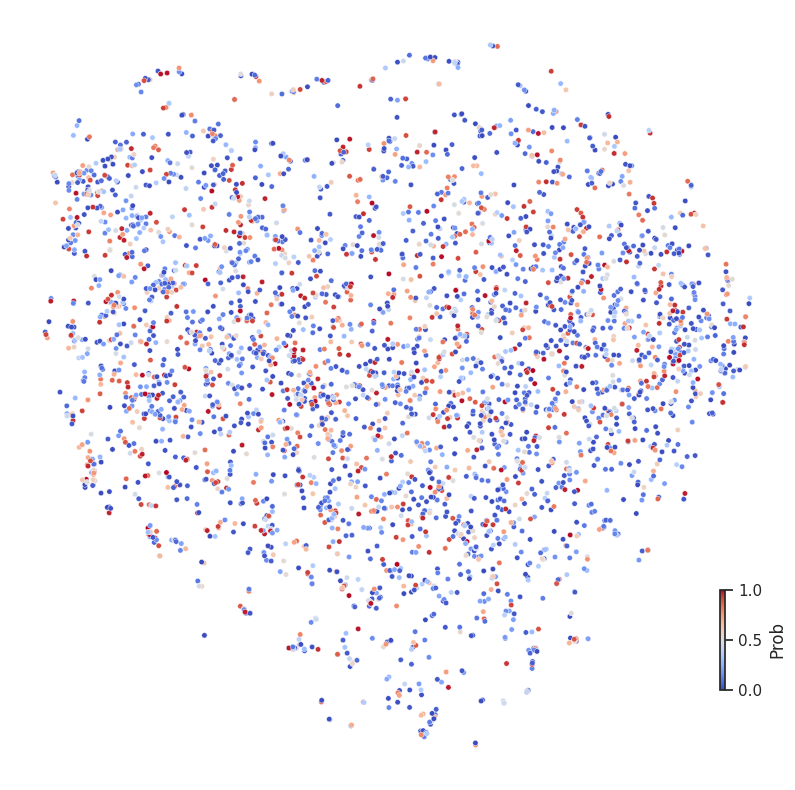

In [59]:
import seaborn as sns
import pylab as pl

fig = pl.figure(figsize=(10,10))
ax = pl.subplot(1,1,1)

g=sns.scatterplot(x='x',y='y',data=ER_pred1,ax=ax,s=15,
                  c=ER_pred1.ERa_TRANS_pred,cmap='coolwarm',vmin=0,vmax=1,legend=False)
sm = pl.cm.ScalarMappable(cmap="coolwarm", norm=None)
sm.set_array([])
ax2 = fig.add_axes([0.75,0.2,0.1,0.1])
fig.colorbar(sm,ax=ax2,label='Prob')
ax.set_axis_off()
ax2.set_axis_off()

In [60]:

# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib.colors import LogNorm
# #ER_pred1.insert(3,'pred_bin',ER_pred1.ERa_TRANS_pred.apply(lambda x: 'Act' if x>0.5 else 'Inactive'))
# pal1 = dict(Act='red',Inactive='blue')
# g = sns.JointGrid(data=ER_pred1,
#                   dropna=True,
#                   x='x',y='y',
#                   hue='pred_bin',
#                   height=8,
#                   palette=pal1
#                 )
# g.plot_joint(sns.kdeplot,fill=True,alpha=0.3,lines=True,
#              s=10)
# #g.ax_joint.set_xscale('log')
# #g.ax_joint.set_yscale('log')
# #g.ax_joint.set_ylim(0,30)
# #g.ax_joint.set_xlim(1e-3,100)
# sns.boxplot(data=X,x=g.hue,y=g.y,ax=g.ax_marg_y,fliersize=0.2,linewidth=0.4,palette=pal1)
# sns.boxplot(data=X,y=g.hue,x=g.x,ax=g.ax_marg_x,fliersize=0.2,linewidth=0.4,palette=pal1)



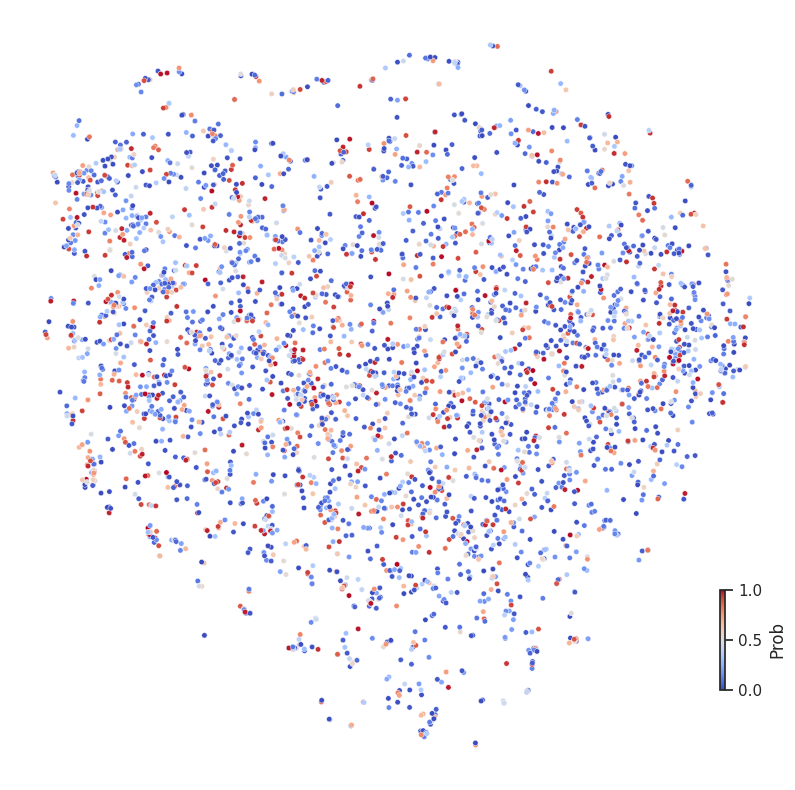

In [61]:
import seaborn as sns
import pylab as pl

fig = pl.figure(figsize=(10,10))
ax = pl.subplot(1,1,1)

g=sns.scatterplot(x='x',y='y',data=ER_pred1,ax=ax,s=15,
                  c=ER_pred1.ERa_TRANS_pred,cmap='coolwarm',vmin=0,vmax=1,legend=False)
sm = pl.cm.ScalarMappable(cmap="coolwarm", norm=None)
sm.set_array([])
ax2 = fig.add_axes([0.75,0.2,0.1,0.1])
fig.colorbar(sm,ax=ax2,label='Prob')
ax.set_axis_off()
ax2.set_axis_off()

## Neighbours

In [39]:
from sklearn.neighbors import NearestNeighbors

NN = NearestNeighbors(n_neighbors=10,metric='euclidean')
NN.fit(AFP1_emb)
Dist,Ind = NN.kneighbors()


In [86]:
DTXSID_keep=CH_ATG.dsstox_sid[SID_keep].tolist()

In [78]:
AFP1_emb.shape,Ind.shape,XY.shape,ER_XY.shape,Dist.shape,len(SID_keep)

((3469, 160), (3469, 10), (3469, 3), (1668, 23), (3469, 10), 3469)

In [87]:
#AFP1_emb_nn = pd.DataFrame([XY.dtxsid.iloc[x].tolist() for x in Ind])
AFP1_emb_nn = pd.DataFrame([[DTXSID_keep[i] for i in x] for x in Ind])
AFP1_emb_nn.index = DTXSID_keep
AFP1_emb_nn.columns=['nn_{}'.format(i) for i in range(1,11)]



In [88]:
AFP1_emb_nn.head()

,nn_1,nn_2,nn_3,nn_4,nn_5,nn_6,nn_7,nn_8,nn_9,nn_10
DTXSID0020232,DTXSID5021336,DTXSID9026132,DTXSID6045400,DTXSID2052281,DTXSID9020370,DTXSID2027414,DTXSID9047463,DTXSID4044664,DTXSID0044999,DTXSID6024200
DTXSID0020236,DTXSID7042190,DTXSID8042422,DTXSID4052550,DTXSID8042426,DTXSID9027312,DTXSID5021885,DTXSID5023114,DTXSID1020223,DTXSID8026060,DTXSID7026235
DTXSID0020280,DTXSID4021971,DTXSID5020281,DTXSID1041263,DTXSID5021831,DTXSID4025791,DTXSID4025793,DTXSID3020964,DTXSID8024999,DTXSID5023792,DTXSID4047599
DTXSID0020282,DTXSID5020283,DTXSID4027494,DTXSID4020402,DTXSID8022406,DTXSID9024930,DTXSID3025881,DTXSID0038887,DTXSID4022311,DTXSID9047592,DTXSID7020427
DTXSID0020284,DTXSID3041247,DTXSID9037749,DTXSID6021248,DTXSID2032342,DTXSID8027793,DTXSID9032533,DTXSID1046970,DTXSID8051914,DTXSID6041503,DTXSID9044536


In [89]:
AFP1_emb_d = pd.DataFrame(Dist,columns=AFP1_emb_nn.columns)
AFP1_emb_d.index=AFP1_emb_nn.index

In [42]:
from functools import reduce

Neg_nn=set(reduce(lambda x,y: x+y,AFP1_emb_nn.loc[SID_neg].iloc[:,:5].apply(lambda x: x.tolist(),axis=1).tolist()))

In [43]:
def classify(x):
    ret = ''
    if x.ERa_TRANS_pred_bin==1 and x.er_class==1:
        ret = 'TP'
    elif x.ERa_TRANS_pred_bin==1 and x.er_class==0:
        ret = 'FP'
    elif x.ERa_TRANS_pred_bin==0 and x.er_class==1:
        ret = 'FN'
    elif x.ERa_TRANS_pred_bin==0 and x.er_class==0:
        ret = 'TN'

    return ret

(-11.131611824035645, 9.985713005065918)

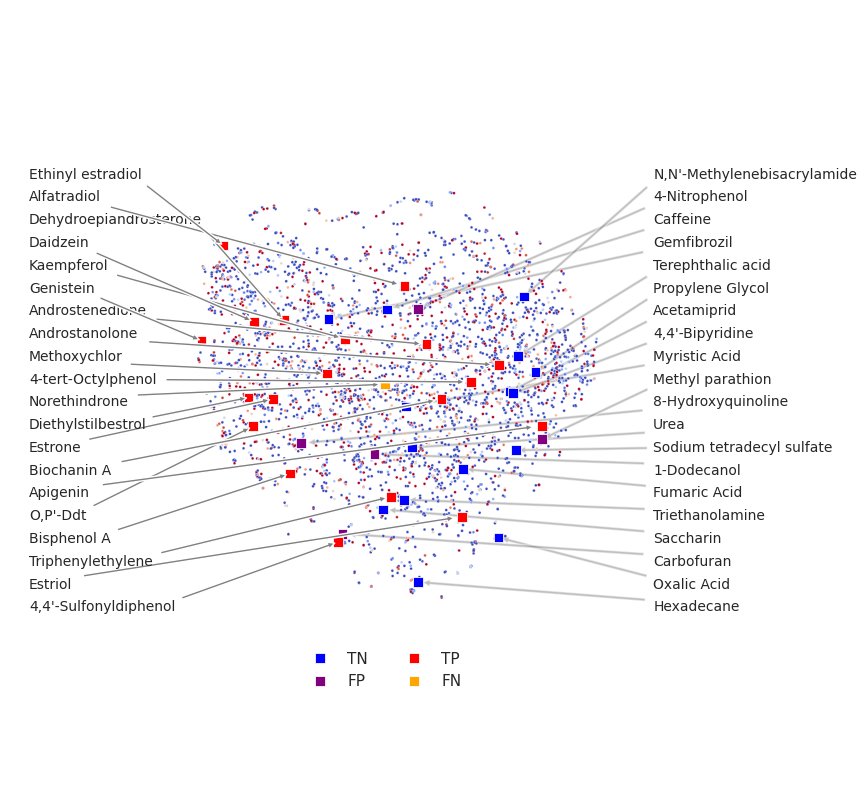

In [91]:
import seaborn as sns
import pylab as pl

fig = pl.figure(figsize=(10,10))
ax = pl.subplot(1,1,1)

# g=sns.scatterplot(x='x',y='y',data=ER_pred1,ax=ax,s=5,
#                   c='grey',legend=False)
g=sns.scatterplot(x='x',y='y',data=ER_pred1,ax=ax,s=4,
                  c=ER_pred1.ERa_TRANS_pred,cmap='coolwarm',vmin=0.2,vmax=0.8,legend=False)
sm = pl.cm.ScalarMappable(cmap="coolwarm", norm=None)
sm.set_array([])


X1_pos = ER_pred1[ER_pred1.dtxsid.isin(SID_pos)]\
            .drop([ 'ERa_TRANS_pred', 'ERE_CIS_pred'],axis=1)\
            .merge(ER_pred,on='dtxsid')

# g=sns.scatterplot(x='x',y='y',data=X1_pos,ax=ax,s=50,
#                   c='red',legend=False)

xmin,xmax=ER_pred1.x.min(),ER_pred1.x.max()
ymin,ymax=ER_pred1.y.min(),ER_pred1.y.max()

dy = (ymax+12-ymin-10)/(X1_pos.shape[0]+1)
y  = ymin-1
x  = xmin-9
for i,Ci in X1_pos.sort_values('y').iterrows():
    y+=dy
    ax.annotate(Ci.chemical,xy=(Ci.x,Ci.y),xytext=(x,y),
                font=dict(size=10),
                arrowprops=dict(facecolor='grey',shrink=0.02,width=2,
                                headwidth=5,headlength=5))
    
    
X1_neg = ER_pred1[ER_pred1.dtxsid.isin(SID_neg)]\
            .drop([ 'ERa_TRANS_pred', 'ERE_CIS_pred'],axis=1)\
            .merge(ER_pred,on='dtxsid')

y  = ymin-1
x  = xmax+3
for i,Ci in X1_neg.sort_values('y').iterrows():
    y+=dy
    ax.annotate(Ci.chemical,xy=(Ci.x,Ci.y),xytext=(x,y),
                font=dict(size=10),zorder=0,
                arrowprops=dict(facecolor='grey',shrink=0.02,width=2,
                                headwidth=5,headlength=5,alpha=0.5))
X1 = pd.concat((X1_neg,X1_pos))
X1.insert(X1.shape[1],'Pred',X1.apply(classify,axis=1))
g=sns.scatterplot(x='x',y='y',data=X1,ax=ax,s=50,marker='s',
                  hue=X1.Pred,palette=dict(TP='red',TN='blue',FP='purple',FN='orange'))


sns.move_legend(
    g, "lower right",ncol=2, title="", frameon=False,
    bbox_to_anchor=(.6, 0.1), 
)
# ax2 = fig.add_axes([0.75,0.2,0.1,0.1])
ax.set_axis_off()
# ax2.set_axis_off()

ax.set_xlim(xmin-10,xmax+10)
ax.set_ylim(ymin-5,ymax+5)



/opt/miniconda3/envs/dc310/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


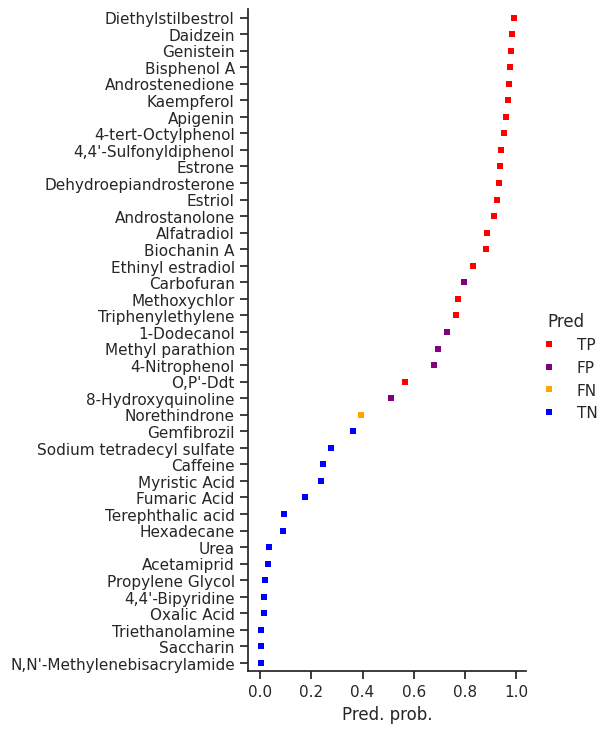

In [87]:
import seaborn as sns
sns.set(style='ticks')
g=sns.catplot(data=X1.sort_values('ERa_TRANS_pred',ascending=False),x='ERa_TRANS_pred',y='chemical',
            hue='Pred',palette=dict(TP='red',TN='blue',FP='purple',FN='orange'),
              marker='s',
            aspect=0.8,height=7.5)
                  
g.set(xlabel='Pred. prob.',ylabel='')

In [156]:
X = ER_pred0.merge(CHM.reset_index().rename(columns=dict(dsstox_sid='dtxsid')),
                on = 'dtxsid')
X[X.dtxsid.isin(SID_pos)]    

,dtxsid,ERa_TRANS_pred,ERE_CIS_pred,name
417,DTXSID1022394,0.882639,0.911759,Biochanin A
1048,DTXSID3020465,0.989776,0.986249,Diethylstilbestrol
1106,DTXSID3022320,0.765105,0.959943,Triphenylethylene
1109,DTXSID3022409,0.940038,0.909736,"4,4'-Sulfonyldiphenol"
1386,DTXSID4020379,0.933943,0.888659,Dehydroepiandrosterone
1450,DTXSID4022367,0.936119,0.879401,Estrone
1754,DTXSID5020576,0.828903,0.835434,17alpha-Ethinylestradiol
1812,DTXSID5022308,0.979274,0.991009,Genistein
2150,DTXSID6022345,0.565000,0.928227,"o,p'-DDT"
2151,DTXSID6022391,0.960533,0.987536,Apigenin


In [157]:
X[X.dtxsid.isin(SID_neg)]    

,dtxsid,ERa_TRANS_pred,ERE_CIS_pred,name
0,DTXSID0020232,0.246407,0.265012,Caffeine
23,DTXSID0020652,0.364504,0.670539,Gemfibrozil
35,DTXSID0021206,0.020685,0.035329,"1,2-Propylene glycol"
54,DTXSID0021834,0.679335,0.577243,4-Nitrophenol
116,DTXSID0025816,0.015843,0.067690,Oxalic acid
130,DTXSID0027195,0.090251,0.051737,Hexadecane
167,DTXSID0034300,0.030365,0.172907,Acetamiprid
368,DTXSID1020855,0.692475,0.972830,Methyl parathion
852,DTXSID2027200,0.016894,0.091198,"4,4'-Bipyridine"
1081,DTXSID3021518,0.175073,0.197897,Fumaric acid


In [105]:
Res = []
n = 10
ATG_ER = CH_ATG[['dsstox_sid','ATG_ERa_TRANS']].set_index('dsstox_sid')['ATG_ERa_TRANS']
for sid in SID_pos+SID_neg:
    chm = CHM.loc[sid]['name']
    
    print(sid,chm)
    NNi = AFP1_emb_nn.loc[sid].iloc[:n].tolist()
    NND = AFP1_emb_d.loc[sid].iloc[:n].tolist()
    Chi = CHM.loc[NNi].name.tolist()
    Act = ATG_ER.loc[NNi]
    Res.append(pd.DataFrame(dict(source=chm,
                    cls=1 if sid in SID_pos else 0,
                    source_sid=sid,
                    analogs_sid=NNi,
                    analogs_dist=NND,
                    analogs=Chi,
                    analog_act=Act)))
    
NN_Res = pd.concat(Res)       

DTXSID8022377 17alpha-Estradiol
DTXSID3022320 Triphenylethylene
DTXSID3020465 Diethylstilbestrol
DTXSID5022308 Genistein
DTXSID7020182 Bisphenol A
DTXSID5020576 17alpha-Ethinylestradiol
DTXSID9022310 7,4'-Dihydroxyisoflavone
DTXSID4022367 Estrone
DTXSID9022360 4-(1,1,3,3-Tetramethylbutyl)phenol
DTXSID9020827 Methoxychlor
DTXSID9022364 5alpha-Dihydrotestosterone
DTXSID6022345 o,p'-DDT
DTXSID3022409 4,4'-Sulfonyldiphenol
DTXSID9022366 Estriol
DTXSID1022394 Biochanin A
DTXSID8024523 4-Androstene-3,17-dione
DTXSID4020379 Dehydroepiandrosterone
DTXSID9023380 Norethindrone
DTXSID7020768 Kaempferol
DTXSID6022391 Apigenin
DTXSID0025816 Oxalic acid
DTXSID0021206 1,2-Propylene glycol
DTXSID6021666 Tetradecanoic acid
DTXSID0020232 Caffeine
DTXSID5021251 Saccharin
DTXSID1020855 Methyl parathion
DTXSID9021392 Triethanolamine
DTXSID8025595 N,N'-Methylenebisacrylamide
DTXSID9020249 Carbofuran
DTXSID4042416 Sodium myristyl sulfate
DTXSID6026080 Terephthalic acid
DTXSID0020652 Gemfibrozil
DTXSID4021426

In [108]:
NN_Res[NN_Res.source.str.contains('Carbofuran')]

,source,cls,source_sid,analogs_sid,analogs_dist,analogs,analog_act
dsstox_sid,,,,,,,
DTXSID9032327,Carbofuran,0,DTXSID9020249,DTXSID9032327,4.744440,Bendiocarb,1
DTXSID3032626,Carbofuran,0,DTXSID9020249,DTXSID3032626,7.679945,Methiocarb,1
DTXSID6041422,Carbofuran,0,DTXSID9020249,DTXSID6041422,7.736681,7-(Dimethylamino)-4-methylcoumarin,0
DTXSID7032393,Carbofuran,0,DTXSID9020249,DTXSID7032393,7.949300,Fenoxycarb,1
DTXSID3034402,Carbofuran,0,DTXSID9020249,DTXSID3034402,8.165554,Butachlor,1
DTXSID9020247,Carbofuran,0,DTXSID9020249,DTXSID9020247,8.286683,"1-Naphthalenol, 1-(N-methylcarbamate)",1
DTXSID7020764,Carbofuran,0,DTXSID9020249,DTXSID7020764,8.292301,Chlorpropham,1
DTXSID5032525,Carbofuran,0,DTXSID9020249,DTXSID5032525,8.319793,Bifenazate,1
DTXSID6024337,Carbofuran,0,DTXSID9020249,DTXSID6024337,8.404151,Thiobencarb,1


In [103]:
pd.DataFrame(next(i for i in Res if i['source'].startswith('1-Do')))

,source,cls,source_sid,analogs_sid,analogs_dist,analogs,analog_act
dsstox_sid,,,,,,,
DTXSID2021947,1-Dodecanol,0,DTXSID5026918,DTXSID2021947,2.136246,1-Tridecanol,1
DTXSID0026915,1-Dodecanol,0,DTXSID5026918,DTXSID0026915,3.974745,1-Undecanol,0
DTXSID9026926,1-Dodecanol,0,DTXSID5026918,DTXSID9026926,5.046663,1-Tetradecanol,1
DTXSID8044676,1-Dodecanol,0,DTXSID5026918,DTXSID8044676,5.851192,2-(Dodecyloxy)ethanol,0
DTXSID0027270,1-Dodecanol,0,DTXSID5026918,DTXSID0027270,8.447548,1-Pentadecanol,0
DTXSID0048189,1-Dodecanol,0,DTXSID5026918,DTXSID0048189,8.862124,Lauryl gallate,1
DTXSID1034769,1-Dodecanol,0,DTXSID5026918,DTXSID1034769,9.101663,N-Vanillylnonanamide,1
DTXSID6020779,1-Dodecanol,0,DTXSID5026918,DTXSID6020779,9.548210,Lithocholic acid,1
DTXSID0037734,1-Dodecanol,0,DTXSID5026918,DTXSID0037734,9.656083,2-Bromohexadecanoic acid,0


In [110]:
NN_Res.to_csv("/home/ishah/ipynb/ml-tox/data/outputs/ATG/atg-afp-er-nn.csv",index=None)

In [111]:
XY.head()

,dtxsid,x,y
0,DTXSID0020232,-0.316553,1.773763
1,DTXSID0020236,7.956553,-0.823657
2,DTXSID0020280,2.655919,0.740343
3,DTXSID0020282,-4.480260,2.579252
4,DTXSID0020284,-9.041265,2.880041


In [112]:
ER_pred1.head()

,dtxsid,x,y,ERa_TRANS_pred,ERE_CIS_pred
0,DTXSID0020232,-0.316553,1.773763,0.246407,0.265012
1,DTXSID0020236,7.956553,-0.823657,0.146052,0.334513
2,DTXSID0020280,2.655919,0.740343,0.177857,0.098997
3,DTXSID0020282,-4.480260,2.579252,0.611845,0.877464
4,DTXSID0020284,-9.041265,2.880041,0.633091,0.953931


In [118]:
NN_Res_xy = ER_pred1.merge(NN_Res.reset_index().rename(columns=dict(dsstox_sid='dtxsid')),
                           on='dtxsid')\
                 .merge(CH_ATG.rename(columns=dict(dsstox_sid='dtxsid')), 
                        on='dtxsid')

In [119]:
NN_Res_xy.head()

,dtxsid,x,y,ERa_TRANS_pred,ERE_CIS_pred,source,cls,source_sid,analogs_sid,analogs_dist,...,ATG_Sp1_CIS,ATG_TAL_CIS,ATG_TA_CIS,ATG_TCF_b_cat_CIS,ATG_TGFb_CIS,ATG_THRa1_TRANS,ATG_VDRE_CIS,ATG_VDR_TRANS,ATG_Xbp1_CIS,ATG_p53_CIS
0,DTXSID0020288,0.881318,0.352786,0.639099,0.706532,4-Nitrophenol,0,DTXSID0021834,DTXSID0020288,11.338376,...,0,0,0,0,0,0,1,0,0,0
1,DTXSID0020446,-1.016615,2.259752,0.038649,0.323107,Methyl parathion,0,DTXSID1020855,DTXSID0020446,14.430167,...,0,0,1,0,0,0,1,0,0,0
2,DTXSID0020523,1.316073,2.427905,0.148414,0.121791,4-Nitrophenol,0,DTXSID0021834,DTXSID0020523,9.718849,...,1,0,0,0,0,0,0,1,0,0
3,DTXSID0020573,-2.038801,-0.940263,0.884233,0.860397,17alpha-Estradiol,1,DTXSID8022377,DTXSID0020573,0.000005,...,0,0,0,0,0,0,0,0,0,0
4,DTXSID0020573,-2.038801,-0.940263,0.884233,0.860397,Estriol,1,DTXSID9022366,DTXSID0020573,6.330413,...,0,0,0,0,0,0,0,0,0,0


### Visualize

In [132]:
CHM

,name
dsstox_sid,
DTXSID0020232,Caffeine
DTXSID0020236,Calcium lactate
DTXSID0020280,1-Chloro-2-nitrobenzene
DTXSID0020282,"4-Chloro-1,3-diaminobenzene"
DTXSID0020284,"2-Chloro-1,4-diaminobenzene sulfate (1:1)"
...,...
DTXSID9051907,2-Isobutyl-3-methoxypyrazine
DTXSID9052505,2-Methyl-1-hexene
DTXSID9052509,4-Hydroxybenzonitrile


In [138]:
CH_ATG.iloc[SID_keep].shape,AFP1_emb.shape,CHM.head(),ER_pred.shape

((3469, 82),
 (3469, 160),
                                                     name
 dsstox_sid                                              
 DTXSID0020232                                   Caffeine
 DTXSID0020236                            Calcium lactate
 DTXSID0020280                    1-Chloro-2-nitrobenzene
 DTXSID0020282                4-Chloro-1,3-diaminobenzene
 DTXSID0020284  2-Chloro-1,4-diaminobenzene sulfate (1:1),
 (1668, 21))

In [140]:
Info = CH_ATG.iloc[SID_keep].merge(CHM.reset_index(),on='dsstox_sid')\
            .rename(columns=dict(dsstox_sid='dtxsid'))
Info.shape

(3469, 83)

In [139]:
All_pred = pd.DataFrame({assay:AFP1_pred[:,Y_names.get_loc(assay),1] for assay in Y_names})
All_pred.insert(0,'dtxsid',Info.dsstox_sid)
All_pred.shape

(3469, 80)

In [141]:
D = '/home/ishah/ipynb/ml-tox/data/outputs/ATG/'
pd.DataFrame(AFP1_emb,columns=['x{}'.format(i) for i in range(AFP1_emb.shape[1])]).to_csv(D+'afp1-full-emb.csv',index=None)
Info.to_csv(D+'atg-chm-info.csv',index=None)
All_pred.to_csv(D+'atg-afp-pred.csv',index=None)

In [142]:
from rdkit import Chem

def generate_morgan_fingerprint(smiles, radius=2, bit_length=2048):
  """
  Generates a Morgan fingerprint for a given SMILES string.

  Args:
      smiles: The SMILES string of the molecule.
      radius: The radius of the fingerprint (default: 2).
      bit_length: The length of the fingerprint (default: 2048).

  Returns:
      A RDKit Morgan fingerprint object.
  """
  mol = Chem.MolFromSmiles(smiles)
  fpgen = Chem.RDKFingerprint(bitLength=bit_length)
  fpgen.FingerprintMol(mol, radius=radius)
  return fpgen.GetFingerprint()

In [143]:
# Example usage
smiles = "CC(=O)O"
fingerprint = generate_morgan_fingerprint(smiles)

# Accessing fingerprint bits
for i in range(fingerprint.GetNumBits()):
  if fingerprint.GetBit(i):
    print(f"Bit {i+1} is set")

ArgumentError: Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint()
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None)

In [158]:
CH_ATG[CH_ATG.dsstox_sid.isin(SID_pos+SID_neg)]['ATG_ERa_TRANS']

0       1
23      1
35      0
54      0
116     0
130     0
167     0
370     0
419     1
854     0
1052    1
1085    0
1110    1
1113    1
1390    1
1425    0
1454    1
1633    0
1759    0
1765    0
1783    0
1818    1
1893    0
2135    0
2157    1
2158    1
2225    0
2432    1
2457    1
2867    0
2904    0
2916    0
3146    0
3169    1
3190    0
3213    1
3215    1
3216    1
3217    1
3228    1
Name: ATG_ERa_TRANS, dtype: int64

In [167]:
X = CH_ATG.merge(CHM,on='dsstox_sid').set_index('dsstox_sid')
X.loc[SID_pos+SID_neg][['name','ATG_ERa_TRANS']]


,name,ATG_ERa_TRANS
dsstox_sid,,
DTXSID8022377,17alpha-Estradiol,0
DTXSID3022320,Triphenylethylene,1
DTXSID3020465,Diethylstilbestrol,1
DTXSID5022308,Genistein,1
DTXSID7020182,Bisphenol A,1
DTXSID5020576,17alpha-Ethinylestradiol,0
DTXSID9022310,"7,4'-Dihydroxyisoflavone",1
DTXSID4022367,Estrone,1
DTXSID9022360,"4-(1,1,3,3-Tetramethylbutyl)phenol",1


In [168]:
CH_ATG.shape

(3479, 82)

In [ ]:
len(SID_ke